# RL and Advanced DL: Домашнее задание 1
Первое ДЗ связано с обучением с подкреплением, и оно придумано для ситуации, когда нейронные сети ещё не нужны, и пространство состояний в целом достаточно маленькое, чтобы можно было обучить хорошую стратегию методами TD-обучения или другими методами обучения с подкреплением. Задание получилось, надеюсь, интересное, но в том числе и достаточно техническое, так что для решения придётся немножко попрограммировать. Поэтому в качестве решения ожидается ссылка на jupyter-ноутбук на вашем github (или публичный, или с доступом для snikolenko); ссылку обязательно нужно прислать в виде сданного домашнего задания на портале Академии. Любые комментарии, новые идеи и рассуждения на тему, как всегда, категорически приветствуются.

## Часть первая, с блекджеком и стратегиями
Мы будем обучаться играть в очень простую, но всё-таки знаменитую и популярную игру: блекджек. Правила блекджека достаточно просты; давайте начнём с самой базовой версии, которая реализована в OpenAI Gym:
* численные значения карт равны от 2 до 10 для карт от двойки до десятки, 10 для валетов, дам и королей;
* туз считается за 11 очков, если общая сумма карт на руке при этом не превосходит 21 (по-английски в этом случае говорят, что на руке есть usable ace), и за 1 очко, если превосходит;
* игроку раздаются две карты, дилеру — одна в открытую и одна в закрытую;
* игрок может совершать одно из двух действий:
hit  — взять ещё одну карту;
stand — не брать больше карт;
* если сумма очков у игрока на руках больше 21, он проигрывает (bust);
* если игрок выбирает stand с суммой не больше 21, дилер добирает карты, пока сумма карт в его руке меньше 17;
* после этого игрок выигрывает, если дилер либо превышает 21, либо получает сумму очков меньше, чем сумма очков у игрока; при равенстве очков объявляется ничья (ставка возвращается);
* в исходных правилах есть ещё дополнительный бонус за natural blackjack: если игрок набирает 21 очко с раздачи, двумя картами, он выигрывает не +1, а +1.5 (полторы ставки).
Именно этот простейший вариант блекджека реализован в OpenAI Gym:
https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py


In [1]:
#!pip install gym==0.17.3

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict
from random import random, randint

from gym.envs.toy_text.blackjack import *
from blackjack import *

In [3]:
def play(env, strategy, action_names=["hit", "stand"], *args, **kwargs):
    
    states = list()
    actions = list()
    rewards = list()
    env.reset()
    finish = False
    
    while not finish:
        states.append(env._get_obs())
        action = strategy(env, *args, **kwargs)
        actions.append(action)
        new_state, reward, done, info = env.step(action)
        rewards.append(reward)
        if done:
            finish = True
    env.close()
    
    return (states, actions, rewards)


def simple_strategy(env):
    '''
    Говорить stand (action = 1), если у нас на руках комбинация в 19, 20 или 21 очко, 
    во всех остальных случаях говорить hit (action = 0).
    '''
    action = 1
    if env._get_obs()[0] >= 19:
        action = 0
    return action


def eps_greedy_strategy(env, epsilon, Q):
    
    state = env._get_obs()
    if random() > epsilon:
        return Q[state].argmax()
    else:
        return randint(0, env.action_space.n - 1)


def average_reward(env, strategy, n_episodes=10, *args, **kwargs):
    
    reward_sum = 0
    
    for i in range(n_episodes):
        reward_sum += play(env, strategy, *args, **kwargs)[-1][-1]
        
    return reward_sum / n_episodes


def monte_carlo_control(env, n_episodes=10, gamma=0.3, decay=0.99, epsilon = 1):
    
    n = env.action_space.n
    Q = defaultdict(lambda: np.zeros(n))
    returns = defaultdict(list)
    N = defaultdict(int)
    
    for i in range(n_episodes):
        states, actions, rewards = play(env, eps_greedy_strategy, Q=Q, epsilon=epsilon)
        G = 0
        for t in range(len(states) - 1, -1, -1):
            state = states[t]
            action = actions[t]
            reward = rewards[t]
            G = gamma * G + reward
            if (state, action) not in zip(states[:t], actions[:t]):
                N[(state, action)] += 1
                Q[state][action] += (G - Q[state][action]) / N[(state, action)]
        epsilon = max(epsilon * decay, 0.001)
    
    best_policy = lambda env, Q: eps_greedy_strategy(env, 0, Q)
    
    return best_policy, Q


def plot_monte_carlo(env, n_episodes_fit=100, n_episodes_test=100000, gammas=0.1, epsilon=1, decay=0.999, verbose=False):
    
    all_rewards = []
    n = env.action_space.n
    
    for gamma in gammas:
        
        print(f"Gamma = {round(gamma, 2)}")
        
        Q = defaultdict(lambda: np.zeros(n))
        N = defaultdict(int)
        
        rewards_gamma = []
        
        for i in range(n_episodes_fit):
            if (i + 1) % (n_episodes_fit // 10) == 0:
                best_policy = lambda env, Q: eps_greedy_strategy(env, 0, Q)
                rewards_gamma.append(average_reward(env, best_policy, n_episodes=n_episodes_test, Q=Q))
                if verbose:
                    print(f"Step:{i + 1}/{n_episodes_fit}, Reward: {rewards_gamma[-1]}")
            states, actions, rewards = play(env, eps_greedy_strategy, Q=Q, epsilon=epsilon)
            G = 0
            
            for t in range(len(states) - 1, -1, -1):
                state = states[t]
                action = actions[t]
                reward = rewards[t]
                G = gamma * G + reward
                if (state, action) not in zip(states[:t], actions[:t]):
                    N[(state, action)] += 1
                    Q[state][action] += (G - Q[state][action]) / N[(state, action)]
            epsilon = max(epsilon * decay, 0.001)
           
        print('----------------------------------------------------------------------------')    
        all_rewards.append(list(rewards_gamma))

    fig, ax = plt.subplots(1, figsize=(15, 7))

    for i in range(len(all_rewards)):
        ax.plot(all_rewards[i], label=f"Gamma: {round(gammas[i], 2)}")
    plt.legend(loc="best")
    plt.title('Rewards')
    plt.show();

Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.

In [4]:
env1 = BlackjackEnv(natural=True)
seed = 42
env1.seed = seed
env1.action_space.seed = seed
env1._max_episode_steps = 1000

In [5]:
play(env1, simple_strategy)

([(8, 10, False), (18, 10, False)], [1, 1], [0.0, -1.0])

Оценим выигрыш простой стратегии

In [6]:
print(average_reward(env1, simple_strategy, n_episodes=100000))

-0.180455


Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.

Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.


Gamma = 0.1
Step:10000/100000, Reward: -0.055555
Step:20000/100000, Reward: -0.056695
Step:30000/100000, Reward: -0.06062
Step:40000/100000, Reward: -0.05575
Step:50000/100000, Reward: -0.056075
Step:60000/100000, Reward: -0.058965
Step:70000/100000, Reward: -0.054445
Step:80000/100000, Reward: -0.061045
Step:90000/100000, Reward: -0.052345
Step:100000/100000, Reward: -0.051625
----------------------------------------------------------------------------
Gamma = 0.15
Step:10000/100000, Reward: -0.11083
Step:20000/100000, Reward: -0.11304
Step:30000/100000, Reward: -0.11334
Step:40000/100000, Reward: -0.120645
Step:50000/100000, Reward: -0.063965
Step:60000/100000, Reward: -0.057415
Step:70000/100000, Reward: -0.060095
Step:80000/100000, Reward: -0.05503
Step:90000/100000, Reward: -0.058805
Step:100000/100000, Reward: -0.059455
----------------------------------------------------------------------------
Gamma = 0.2
Step:10000/100000, Reward: -0.072915
Step:20000/100000, Reward: -0.076365

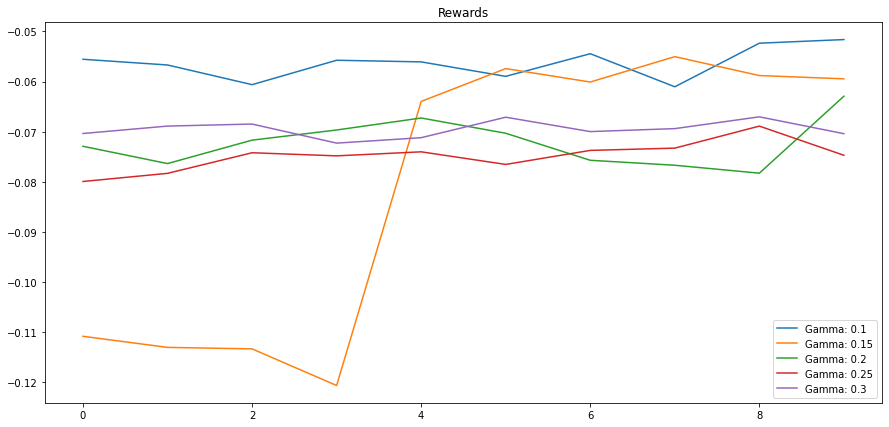

Wall time: 19min 59s


In [8]:
%%time
n_episodes_fit = 100000
n_episodes_test = 100000
gammas = np.linspace(0.1, 0.3, 5)


plot_monte_carlo(env=env1,
                 n_episodes_fit=n_episodes_fit,
                 n_episodes_test=n_episodes_test,
                 gammas=gammas,
                 verbose=True)

## Часть вторая, удвоенная
В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли получится. Но, к счастью, на этом история не заканчивается. Описанные выше правила были упрощёнными, а на самом деле у игрока есть ещё и другие возможности. Реализовывать split может оказаться непросто, поэтому давайте ограничимся удвоением ставки. Итак, у игрока появляется дополнительное действие:\
* double — удвоить ставку; при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается

Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.\
Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.


In [9]:
class Blackjack2(BlackjackEnv):
    
    def step(self, action):
        
        assert self.action_space.contains(action)
        if action == 1: 
            self.player.append(self.draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
                
        elif action == 0:
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5
                
        elif action == 2:
            self.player.append(self.draw_card(self.np_random))
            done = True
            if is_bust(self.player):
                reward = -2.
            else:
                while sum_hand(self.dealer) < 17:
                    self.dealer.append(self.draw_card(self.np_random))
                reward = cmp(score(self.player), score(self.dealer)) * 2
                
        return self._get_obs(), reward, done, {}

In [10]:
env2 = Blackjack2(natural=True)
env2.seed = seed 
env2.action_space.seed = seed

In [11]:
play(env2, simple_strategy)

([(14, 8, True), (15, 8, True), (20, 8, True)], [1, 1, 0], [0.0, 0.0, 1.0])

Gamma = 0.1
Step:10000/100000, Reward: -0.056545
Step:20000/100000, Reward: -0.05383
Step:30000/100000, Reward: -0.056315
Step:40000/100000, Reward: -0.051095
Step:50000/100000, Reward: -0.05288
Step:60000/100000, Reward: -0.052545
Step:70000/100000, Reward: -0.05082
Step:80000/100000, Reward: -0.046895
Step:90000/100000, Reward: -0.05617
Step:100000/100000, Reward: -0.054365
----------------------------------------------------------------------------
Gamma = 0.15
Step:10000/100000, Reward: -0.069315
Step:20000/100000, Reward: -0.06058
Step:30000/100000, Reward: -0.06527
Step:40000/100000, Reward: -0.0639
Step:50000/100000, Reward: -0.061185
Step:60000/100000, Reward: -0.06854
Step:70000/100000, Reward: -0.06233
Step:80000/100000, Reward: -0.057625
Step:90000/100000, Reward: -0.067885
Step:100000/100000, Reward: -0.062455
----------------------------------------------------------------------------
Gamma = 0.2
Step:10000/100000, Reward: -0.07176
Step:20000/100000, Reward: -0.06445
Step:

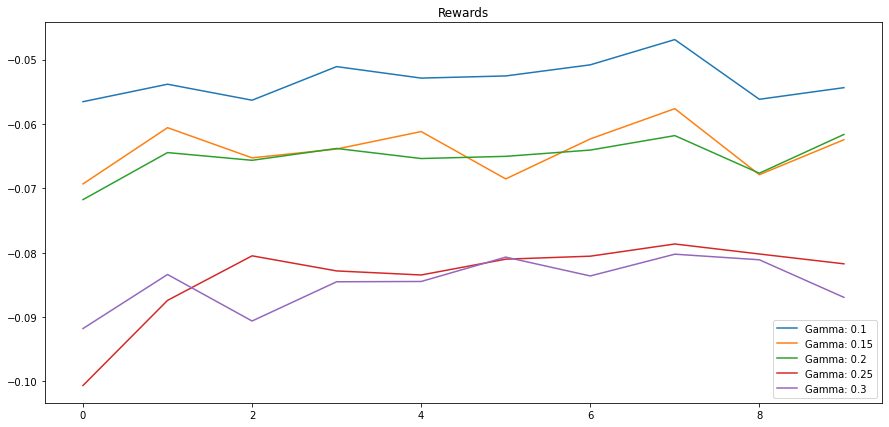

Wall time: 21min 17s


In [12]:
%%time
n_episodes_fit = 100000
n_episodes_test = 100000
gammas = np.linspace(0.1, 0.3, 5)


plot_monte_carlo(env=env2,
                 n_episodes_fit=n_episodes_fit,
                 n_episodes_test=n_episodes_test,
                 gammas=gammas,
                 verbose=True)

## Часть третья, в главной роли — Дастин Хоффман
А теперь давайте вспомним, как играют в блекджек настоящие профессионалы. Дело в том, что в оффлайн-казино обычно не перемешивают колоду после каждой раздачи — это слишком замедляло бы игру. После раздачи карты просто раздаются дальше с верха колоды до тех пор, пока карт не останется слишком мало, и только тогда колода перемешивается; давайте для определённости считать, что наше казино будет перемешивать колоду, в которой осталось меньше 15 карт.


Действительно, если вы будете запоминать, какие карты уже вышли, у вас будет информация о том, какие карты ещё остались, а это позволяет лучше понять, когда нужно удваивать ставку или делать split, а когда лучше не стоит. В настоящем казино могут раздавать карты сразу из нескольких колод, и заслуга Rain Man’а была в том, что он смог считать карты в шести колодах одновременно. Но мы с вами вооружены компьютерами, так что подсчёт можно считать автоматическим.


Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет статья википедии о блекджеке (а возможно, и нет).

Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [13]:
class Blackjack3(Blackjack2):
    
    def __init__(self, natural=False):
        
        # Взято из статьи в Википедии:
        # Эта система описана в замечательной книге Стэнфорда Уонга (англ.) «Профессиональный блек-джек».
        # Вот числовые значения, которые присваиваются картам, выходящим из колоды:
        self.leaving_card_points = {
            1: -1,
            2: 0.5,
            3: 1,
            4: 1,
            5: 1.5,
            6: 1,
            7: 0.5,
            8: 0,
            9: -0.5,
            10: -1,
        }
        super().__init__(natural)
        self.card_counter = 0.0
        self.deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10] * 4

        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2),
            spaces.Box(-22.0, +22.0, shape=(1,1), dtype=np.float32)))
        
        self.reset()

    def draw_card(self, np_random):
        rand_ind = np_random.randint(0, len(self.deck))
        card = self.deck.pop(rand_ind)
        self.card_counter += self.leaving_card_points[card]
        return int(card)

    def draw_hand(self, np_random):
        return [self.draw_card(np_random), self.draw_card(np_random)]

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player), self.card_counter)

    def reset(self):
        if len(self.deck) < 15:
            self.card_counter = 0.0
            self.deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10] * 4
        
        self.dealer = self.draw_hand(self.np_random)
        self.player = self.draw_hand(self.np_random)
        return self._get_obs()

In [14]:
env3 = Blackjack3(natural=True)
env3.seed = seed
env3.action_space.seed = seed

In [15]:
play(env3, simple_strategy)

([(8, 9, False, -1.5),
  (11, 9, False, -0.5),
  (13, 9, False, 0.0),
  (16, 9, False, 1.0),
  (20, 9, False, 2.0)],
 [1, 1, 1, 1, 0],
 [0.0, 0.0, 0.0, 0.0, 0.0])

Gamma = 0.1
Step:100000/1000000, Reward: -0.087605
Step:200000/1000000, Reward: -0.071435
Step:300000/1000000, Reward: -0.067825
Step:400000/1000000, Reward: -0.06725
Step:500000/1000000, Reward: -0.065545
Step:600000/1000000, Reward: -0.064535
Step:700000/1000000, Reward: -0.059775
Step:800000/1000000, Reward: -0.06096
Step:900000/1000000, Reward: -0.06298
Step:1000000/1000000, Reward: -0.061955
----------------------------------------------------------------------------
Gamma = 0.15
Step:100000/1000000, Reward: -0.087255
Step:200000/1000000, Reward: -0.07465
Step:300000/1000000, Reward: -0.073435
Step:400000/1000000, Reward: -0.064875
Step:500000/1000000, Reward: -0.06073
Step:600000/1000000, Reward: -0.05595
Step:700000/1000000, Reward: -0.054265
Step:800000/1000000, Reward: -0.055455
Step:900000/1000000, Reward: -0.063405
Step:1000000/1000000, Reward: -0.058255
----------------------------------------------------------------------------
Gamma = 0.2
Step:100000/1000000, Reward: -0.0

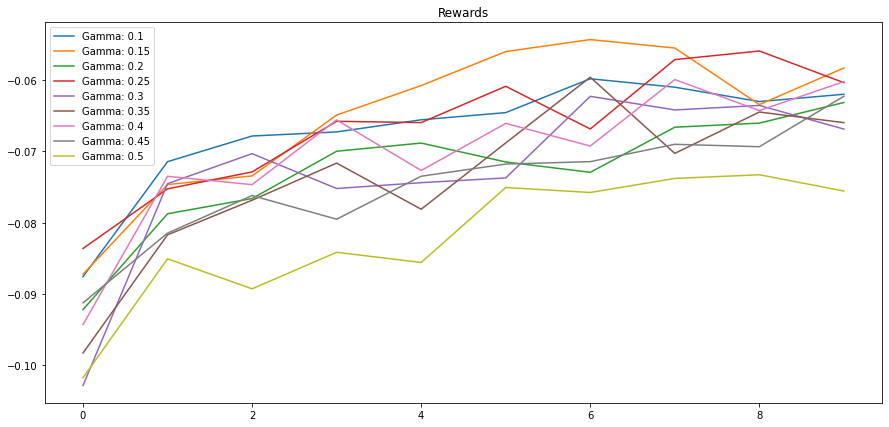

In [17]:
n_episodes_fit = 1000000
n_episodes_test = 100000
gammas = np.linspace(0.1, 0.5, 9)

plot_monte_carlo(env=env3,
                 n_episodes_fit=n_episodes_fit,
                 n_episodes_test=n_episodes_test,
                 gammas=gammas,
                 verbose=True)

Gamma = 0.15
Step:10000000/100000000, Reward: -0.035931
Step:20000000/100000000, Reward: -0.027215
Step:30000000/100000000, Reward: -0.023196
Step:40000000/100000000, Reward: -0.017008
Step:50000000/100000000, Reward: -0.013852
Step:60000000/100000000, Reward: -0.011939
Step:70000000/100000000, Reward: -0.009845
Step:80000000/100000000, Reward: -0.012047
Step:90000000/100000000, Reward: -0.009685
Step:100000000/100000000, Reward: -0.007056
----------------------------------------------------------------------------


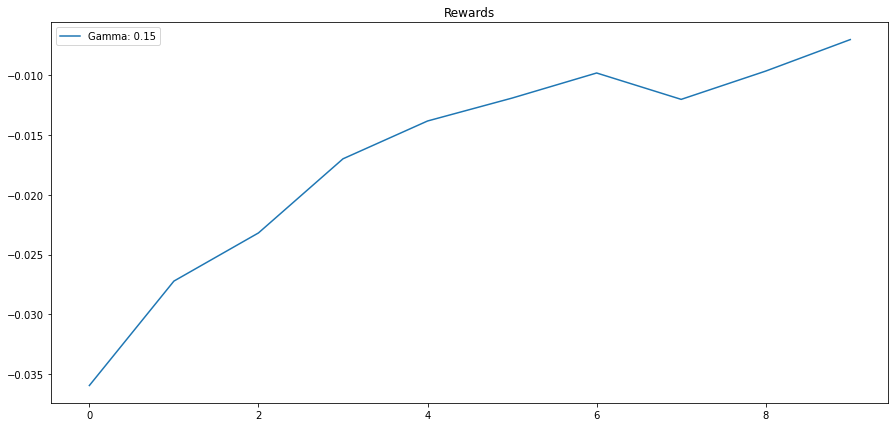

Wall time: 2h 38min 1s


In [18]:
%%time
n_episodes_fit = 100000000
n_episodes_test = 500000
gammas = [0.15]

plot_monte_carlo(env=env3,
                 n_episodes_fit=n_episodes_fit,
                 n_episodes_test=n_episodes_test,
                 gammas=gammas,
                 verbose=True)